In [1]:
import torch
import torch.nn as nn
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)


def unicodeToAscii(s):
	return ''.join(
		c for c in unicodedata.normalize('NFD', s)
		if unicodedata.category(c) != 'Mn'
		and c in all_letters)


def readLines(filename):
	lines = open(filename, encoding='utf-8').read().strip().split('\n')
	return [unicodeToAscii(line) for line in lines]


def letterToIndex(letter):
	return all_letters.find(letter)


def letterToTensor(letter):
	tensor = torch.zeros(1, n_letters)
	tensor[0][letterToIndex(letter)] = 1
	return tensor


def lineToTensor(line):
	tensor = torch.zeros(len(line), 1, n_letters)
	for li, letter in enumerate(line):
		tensor[li][0][letterToIndex(letter)] = 1
	return tensor

In [9]:
class RNN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()

		self.hidden_size = hidden_size

		# self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
		self.i2h = nn.Linear(input_size, hidden_size)
		self.h2h = nn.Linear(hidden_size, hidden_size)
		self.h2o = nn.Linear(hidden_size, output_size)
		
		self.tanh = nn.Tanh()
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, input, hidden):
		# combined = torch.cat((input, hidden), 1)
		# hidden = self.i2h(combined)
		hidden = self.tanh(self.i2h(input) + self.h2h(hidden))
		output = self.softmax(self.h2o(hidden))

		return output, hidden

	def initHidden(self):
		return torch.zeros(1, self.hidden_size)

In [10]:
def categoryFromOutput(output):
	top_n, top_i = output.topk(1)
	category_i = top_i[0].item()
	return all_categories[category_i], category_i


def randomChoice(l):
	return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
	category = randomChoice(all_categories)
	line = randomChoice(category_lines[category])
	category_tensor = torch.tensor([all_categories.index(category)], 
		dtype=torch.long)
	line_tensor = lineToTensor(line)
	return category, line, category_tensor, line_tensor

In [11]:
def train(category_tensor, line_tensor):
	rnn.train()

	hidden = rnn.initHidden()

	optimizer.zero_grad()

	for i in range(line_tensor.size()[0]):
		output, hidden = rnn(line_tensor[i], hidden)

	loss = criterion(output, category_tensor)
	loss.backward()

	optimizer.step()

	return output, loss.item()


def evaluate(line_tensor):

	rnn.eval()
	with torch.no_grad():
		hidden = rnn.initHidden()

		for i in range(line_tensor.size()[0]):
			output, hidden = rnn(line_tensor[i], hidden)

		return output

# data handling

In [12]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(findFiles('data/data/names/*.txt'))
print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

for filename in findFiles('data/data/names/*.txt'):
	category = os.path.splitext(os.path.basename(filename))[0]
	all_categories.append(category)
	lines = readLines(filename)
	category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Italian'][:5])

['data/data/names\\Arabic.txt', 'data/data/names\\Chinese.txt', 'data/data/names\\Czech.txt', 'data/data/names\\Dutch.txt', 'data/data/names\\English.txt', 'data/data/names\\French.txt', 'data/data/names\\German.txt', 'data/data/names\\Greek.txt', 'data/data/names\\Irish.txt', 'data/data/names\\Italian.txt', 'data/data/names\\Japanese.txt', 'data/data/names\\Korean.txt', 'data/data/names\\Polish.txt', 'data/data/names\\Portuguese.txt', 'data/data/names\\Russian.txt', 'data/data/names\\Scottish.txt', 'data/data/names\\Spanish.txt', 'data/data/names\\Vietnamese.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [13]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# neural network

In [14]:
n_hidden = 128
learning_rate = 1e-4
n_iters = 100000
# n_iters = 1000
print_every = 5000
plot_every = 1000

rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output.shape)
print(output)
print(categoryFromOutput(output))


for i  in range(10):
	category, line, category_tensor, line_tensor = randomTrainingExample()
	print(f'category = {category}, line = {line}')


current_loss = 0
all_losses = []

torch.Size([1, 18])
tensor([[-2.7292, -2.8297, -2.8875, -2.9180, -2.9252, -2.8961, -2.9553, -2.9884,
         -2.9600, -2.9734, -2.8480, -2.8060, -2.9877, -2.7836, -2.7903, -2.9848,
         -2.9069, -2.9105]], grad_fn=<LogSoftmaxBackward0>)
('Arabic', 0)
category = Scottish, line = Gray
category = Portuguese, line = Gaspar
category = Korean, line = Chong
category = Italian, line = Pavone
category = English, line = Goulding
category = Vietnamese, line = Dang
category = Czech, line = Slapnickova
category = Portuguese, line = Silva
category = German, line = Schlusser
category = Polish, line = Sniegowski


# train the model

5000 5% 2.8318 Sutherland / French x Scottish
10000 10% 0.7261 Slaski / Polish v
15000 15% 1.7007 Mateus / Portuguese v
20000 20% 1.4342 Pokorny / Czech v
25000 25% 0.1578 Nomikos / Greek v
30000 30% 1.8424 Deniel / German x French
35000 35% 0.5692 Yoon / Korean v
40000 40% 2.2745 Meszes / Dutch x Czech
45000 45% 4.1305 Desai / Arabic x English
50000 50% 0.1016 Ponedelkov / Russian v
55000 55% 1.7509 Simon / English v
60000 60% 0.3973 Rademakers / Dutch v
65000 65% 1.3019 Machado / Irish x Portuguese
70000 70% 0.5036 Ko / Korean v
75000 75% 0.3669 Van / Vietnamese v
80000 80% 1.2456 Pozzi / Polish x Italian
85000 85% 1.7445 Toma / Japanese x Arabic
90000 90% 0.2606 Ly / Vietnamese v
95000 95% 2.4584 Dale / French x Dutch
100000 100% 0.7718 Sarto / Italian v


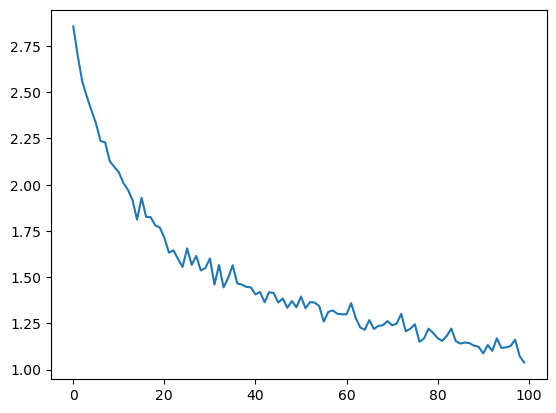

In [15]:
for iter in range(1, n_iters + 1):
	category, line, category_tensor, line_tensor = randomTrainingExample()
	output, loss = train(category_tensor, line_tensor)
	current_loss += loss

	if iter % print_every == 0:
		guess, guess_i = categoryFromOutput(output)
		correct = 'v' if guess == category else f'x {category}'

		print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, 
			loss, line, guess, correct))

	if iter % plot_every == 0:
		all_losses.append(current_loss / plot_every)
		current_loss = 0


plt.figure()
plt.plot(all_losses)

# evaluate the results

In [16]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
	category, line, category_tensor, line_tensor = randomTrainingExample()
	output = evaluate(line_tensor)
	guess, guess_i = categoryFromOutput(output)
	category_i = all_categories.index(category)
	confusion[category_i][guess_i] += 1

for i in range(n_categories):
	confusion[i] = confusion[i] / confusion[i].sum()

## Set up plot

C:\Users\tamar\AppData\Local\Temp\ipykernel_25256\3295808701.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\tamar\AppData\Local\Temp\ipykernel_25256\3295808701.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


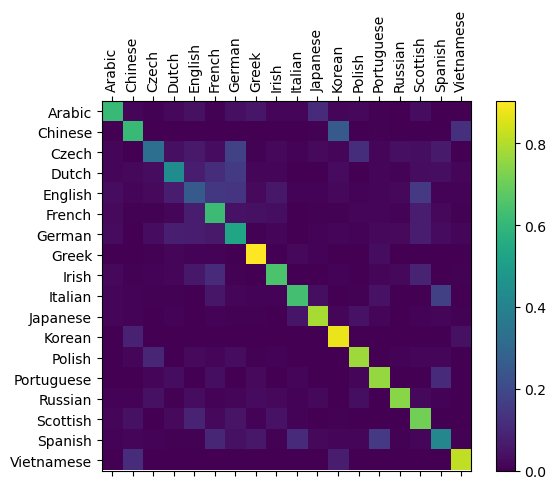

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()